In [6]:
# import relevant libraries
import calendar
import datetime as dt
import dateutil.parser as datepar
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
#from scipy import stats
import statsmodels.api as sm 


from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier


# plotting in the notebook and setting current directory
%matplotlib inline

ImportError: cannot import name normalize

# 1. Import and Preprocess Data

In [2]:
# import training and test data into dataframe format
df_raw_train = pd.read_csv('train_data.csv', sep=',', header=0)
df_raw_test = pd.read_csv('test_data.csv', sep=',', header=0)


# Quick overview on dataset
for column in df_raw_train.columns.values:
    print ("{}: {}".format(column,pd.unique(df_raw_train[column]).size))
    
df_raw_train.shape;
df_raw_train.head();

NameError: name 'pd' is not defined

In [402]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False


# convert currency to float number
df_raw_train['Price'] = df_raw_train['Price'].apply(lambda x: float(str(x)[1:].replace(",", "")) 
                                                    if isfloat(str(x)[1:]) else np.NaN)
df_raw_test['Price'] = df_raw_train['Price'].apply(lambda x: float(str(x)[1:].replace(",", "")) 
                                                   if isfloat(str(x)[1:]) else np.NaN)

# put target label to be -1 to label test data
df_raw_test['target'] = -1

In [403]:
#check the class distribution to see if negative downsampling is needed
 
Total = df_raw_train['target'].count()
No_Pos = df_raw_train[df_raw_train['target'] == 1]['target'].count()
No_Neg = df_raw_train[df_raw_train['target'] == 0]['target'].count()

print 'Total number of event = ', Total
print 'Number of positive event = ', No_Pos, ' % of positive= ', 100.0 * No_Pos / Total
print 'Number of negative event = ', No_Neg, ' % of negative = ', 100.0 * No_Neg / Total

Total number of event =  12422
Number of positive event =  5224  % of positive=  42.0544195782
Number of negative event =  7198  % of negative =  57.9455804218


In [404]:
# function to convert timestamp string into datetime object

def str_to_datetime(time_stamp):
    # Convert time_stamp into datetime object: year, month, day, hour, min, sec
    parsed_time = datepar.parse(time_stamp, ignoretz=None).timetuple()
    return dt.datetime(parsed_time[0], parsed_time[1], parsed_time[2], 
                       parsed_time[3], parsed_time[4], parsed_time[5])

def pre_process_df(df, *args):
    df_pp = df.copy()
    time_col = [col for col in args]
    for col in time_col:
        df_pp[col] = df_pp[col].map(lambda x: str_to_datetime(x))
    return df_pp

df_raw = df_raw_train.append(df_raw_test, ignore_index=True)
df_data = pre_process_df(df_raw, 'Snapshot', 'Day', 'Birth')

swql = .5*(df_data["Sys_p90"]+ df_data["Sys_p50"]);
#Sys_weighted_quantile_loss

uwql = .5*(df_data["User_p90"]+ df_data["User_p50"]);
#User_weighted_quantile_loss

df_data['target_mod'] =  swql-uwql>0 ;

#for column in df_train.columns.values:
  #  print ("{}: {}".format(column,pd.unique(df_train[column]).size))


In [405]:
# convert to day of week

def to_day_of_week(date_str):
    return calendar.day_name[date_str.weekday()]

df_data['Week_day'] = df_data['Snapshot'].map(lambda x: to_day_of_week(x))
df_data['Age'] = (df_data['Day'] - df_data['Birth']).astype('timedelta64[D]').astype(int)
#df_data = df_data.drop(df_data['Age'] < 0)


In [406]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_data['Day'].min(), end=df_data['Day'].max())

def close_to_holidays(date, holidays):
    for d in holidays:
        if 0 <= (d - date).days <= 7:
            return True
        else:
            return False

df_data['before_holidays'] = df_data['Day'].apply(lambda x: close_to_holidays(x, holidays))

# 2. Exploratory data analysis


In [407]:
# Look at the distribution of each potential feature in training set

df_train = df_data[df_data['target'] != -1]
list_col = list(df_data.columns)
print list_col

['Birth', 'Day', 'Has_Promo', 'Item', 'Model', 'PNT', 'Price', 'Product_Line', 'Reason', 'Snapshot', 'Sold', 'Sys_p50', 'Sys_p90', 'User', 'User_p50', 'User_p90', 'id', 'target', 'target_mod', 'Week_day', 'Age', 'before_holidays']


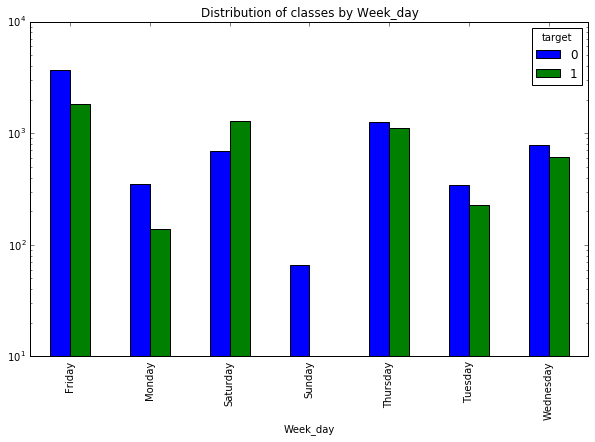

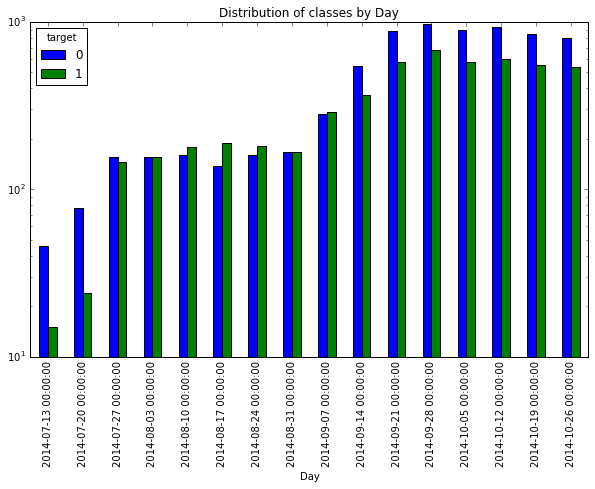

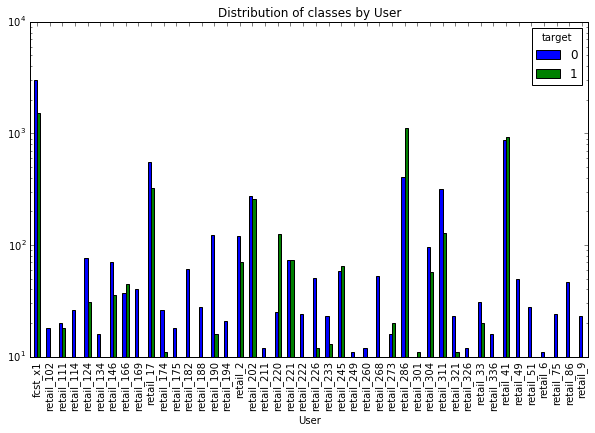

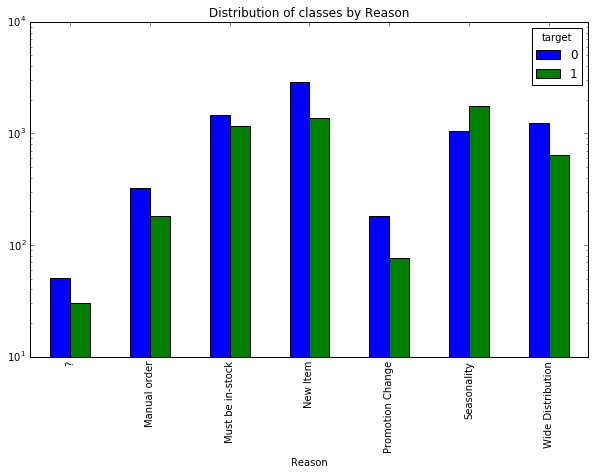

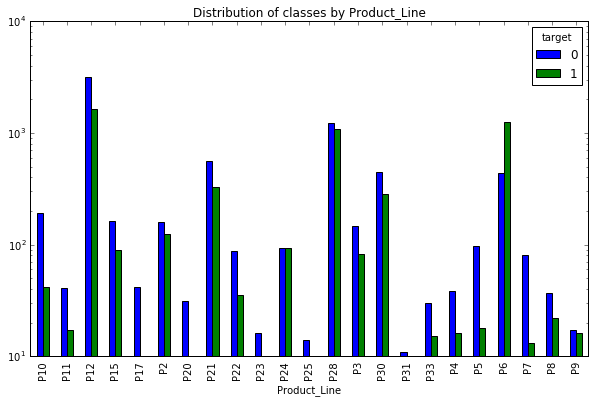

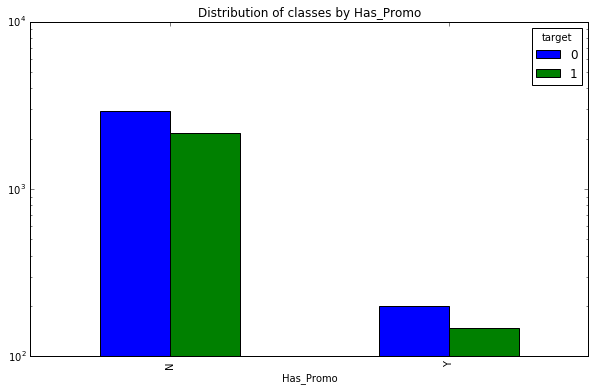

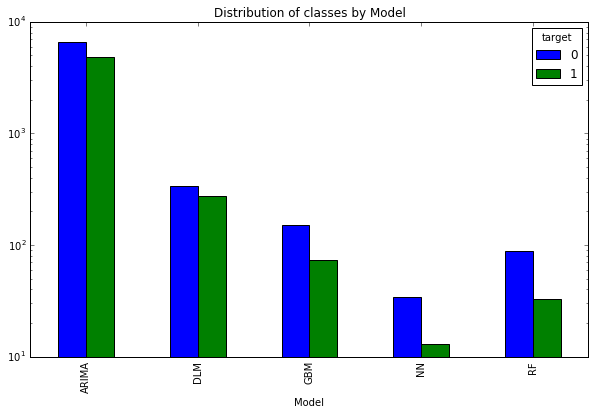

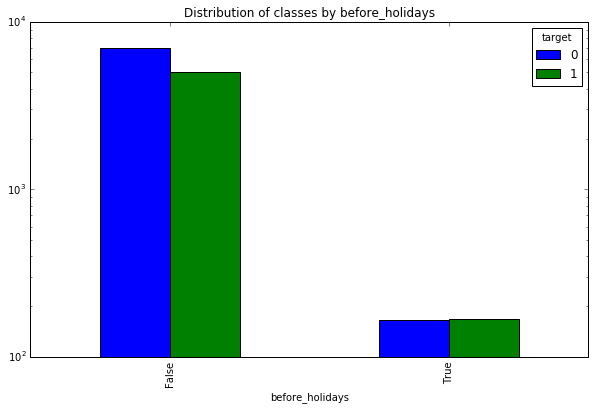

In [408]:
def plot_category_dist(df_train, col):
    df_group = df_train.groupby([col, 'target']).size()
    df_group[df_group >10].unstack().plot(kind='bar', stacked=False, title="Distribution of classes by {}".format(col), 
                                          logy=True, figsize=(10, 6))  
    plt.savefig("hist_{}.png".format(col))

category = ['Week_day', 'Day', 'User', 'Reason', 'Product_Line', 'Has_Promo', 'Model', 'before_holidays']
for item in category:
    plot_category_dist(df_train, item)

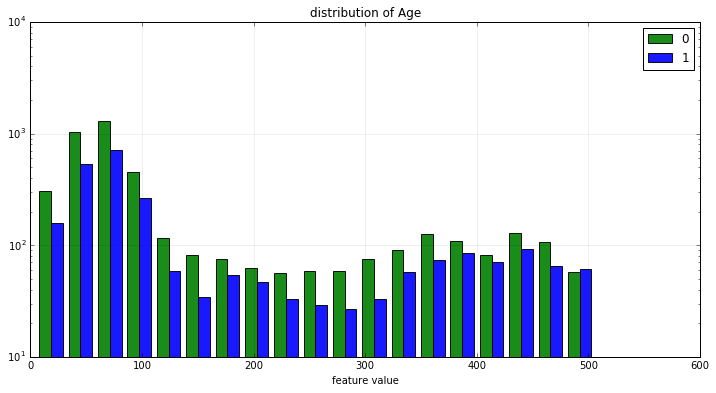

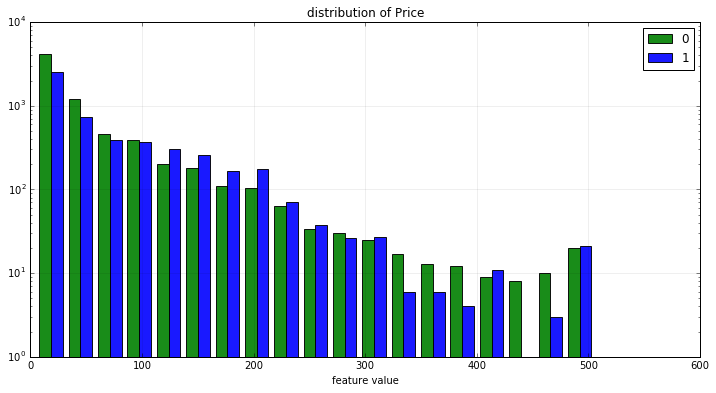

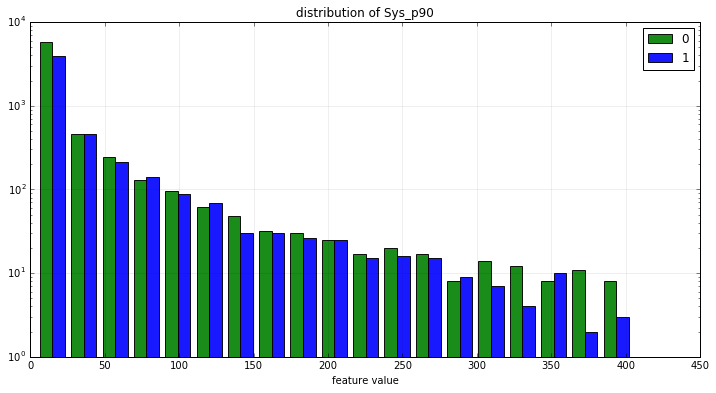

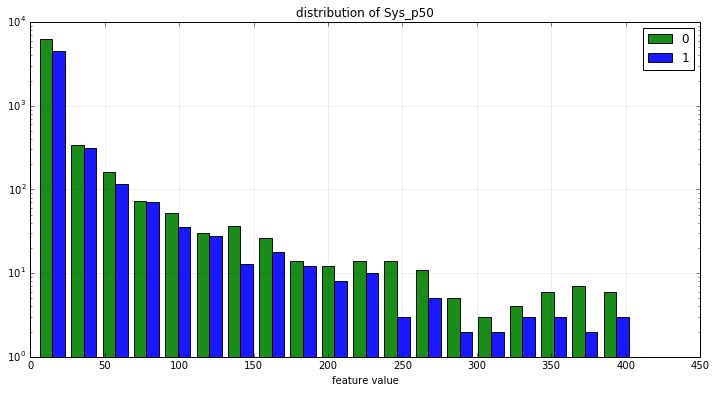

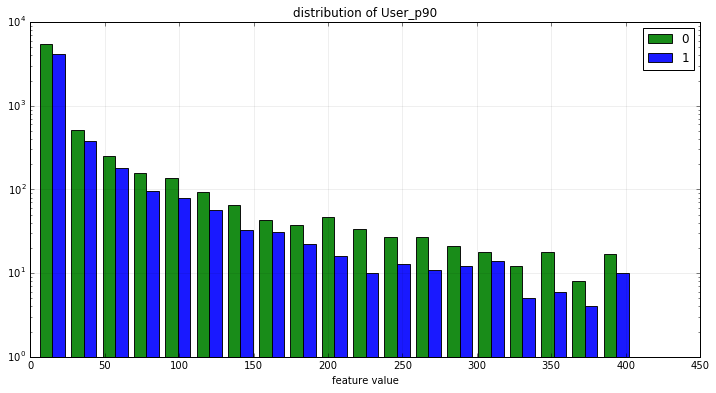

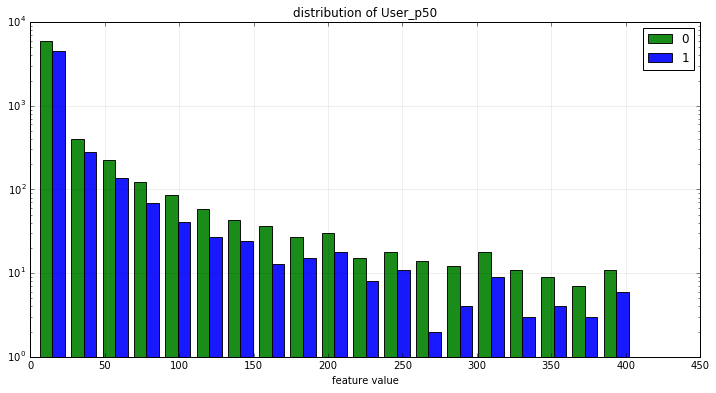

In [409]:
def plot_numeric_dist(df_train, col, b_min, b_max, b):
    raw_pos = df_train[df_train['target'] == 1][col].dropna().values
    raw_neg = df_train[df_train['target'] == 0][col].dropna().values

    raw_bins = np.linspace(b_min, b_max, b)
    hist_raw_pos = np.histogram(raw_pos, bins=raw_bins)
    hist_raw_neg = np.histogram(raw_neg, bins=raw_bins)
    hist_pos, bins = hist_raw_pos
    hist_neg, bins = hist_raw_neg

    width = 0.4 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    fig = plt.figure(figsize=(12,6))
    plt.bar(center, hist_neg, align='center', width=width, alpha=0.9, label='0', color='g')
    plt.bar(center + width, hist_pos, align='center', width=width, alpha=0.9, label='1', color='b')
    plt.legend(loc='upper right')

    plt.title('distribution of {}'.format(col))
    plt.xlabel('feature value')

    plt.grid(b=True, which='major', linestyle='-', alpha=0.12)
    plt.yscale('log', nonposy='clip')

    plt.savefig("hist_{}.png".format(col))
    plt.show()

plot_numeric_dist(df_train, 'Age', 0, 500, 20)
plot_numeric_dist(df_train, 'Price', 0, 500, 20)
plot_numeric_dist(df_train, 'Sys_p90', 0, 400, 20)
plot_numeric_dist(df_train, 'Sys_p50', 0, 400, 20)
plot_numeric_dist(df_train, 'User_p90', 0, 400, 20)
plot_numeric_dist(df_train, 'User_p50', 0, 400, 20)


# 3. Feature extraction and scaling

In [410]:
# extract features
# list of binary features: week_day, user, reason, product_line, has_promo, model
# list of numeric features: price, pnt, sys_p90, sys_p50, user_p_90, sold


# feature_extractor function
def extract_df_feature(df, category_features, numeric_features):    
    return pd.concat([df['target'], df[numeric_features], pd.get_dummies(df[category_features])], 
                     axis=1) 


category_features = [ 'Week_day', 'User', 'Reason', 'Product_Line', 'Has_Promo', 'Model', 'before_holidays']
numeric_features = ['Price','PNT', 'Sys_p90', 'Sys_p50', 'User_p90', 'User_p50', 'Age']
    
df_feature = extract_df_feature(df_data, category_features, numeric_features)
df_train_feature = df_feature[df_feature['target'] != -1]
df_test_feature = df_feature[df_feature['target'] == -1].drop('target', 1)


# Look at the number of samples vs the number of features to make sure there is enough data for training
print "(# of samples, # of features) = ", df_test_feature.shape

df_feature.dtypes;

(# of samples, # of features) =  (6159, 330)


In [411]:
scaler = RobustScaler()

df_scaled_train = pd.DataFrame(scaler.fit_transform(df_train_feature.fillna(df_train_feature.mean())), 
                               columns=df_train_feature.columns)
df_scaled_test = pd.DataFrame(scaler.fit_transform(df_test_feature.fillna(df_test_feature.mean())), 
                              columns=df_test_feature.columns)

Y, X = df_scaled_train.values[:, 0], df_scaled_train.values[:, 1:]
X_test = df_scaled_test.values

# 4. Model testing with learning curves

In [412]:
def plot_learning_curves(model, X, Y, label):
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, train_sizes=np.linspace(0.1, 1.0, 5),
                                                            scoring='accuracy', cv=4,
                                                            n_jobs=1, pre_dispatch="all")
    fig = plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_scores.mean(1), 'o-', color="g", label="train_score")
    plt.plot(train_sizes, test_scores.mean(1), 'o-', color="r", label="validation_score")

    plt.xlabel("Train size")
    plt.ylabel("Accuracy")
    plt.title('Learning curves of {}'.format(label))
    plt.legend(loc="best")
    plt.grid(b=True, which='major', linestyle='-', alpha=0.12)
    plt.savefig("learning_{}.png".format(label))

    plt.show()

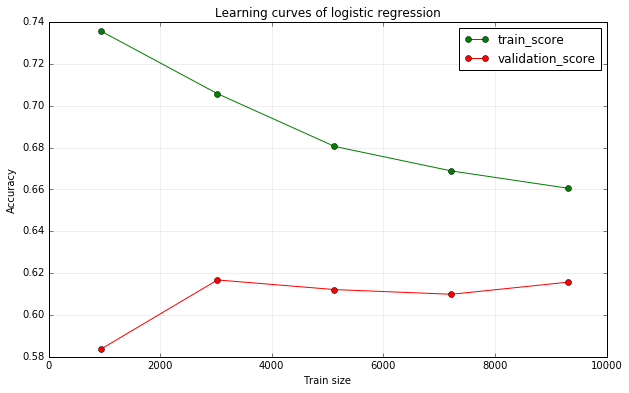

In [413]:
LR = LogisticRegression()
plot_learning_curves(LR, X, Y, 'logistic regression')

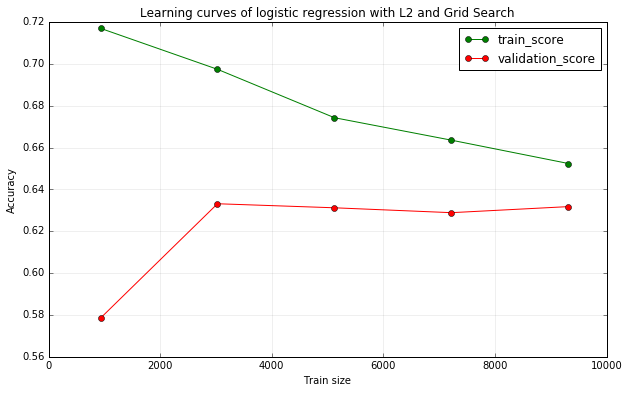

0.03


In [414]:
param_grid = {'C': [.005, .01,.02 ,.03, .05]}

LR_l2 = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)

plot_learning_curves(LR_l2, X, Y, 'logistic regression with L2 and Grid Search')

print LR_l2_model.best_params_['C']


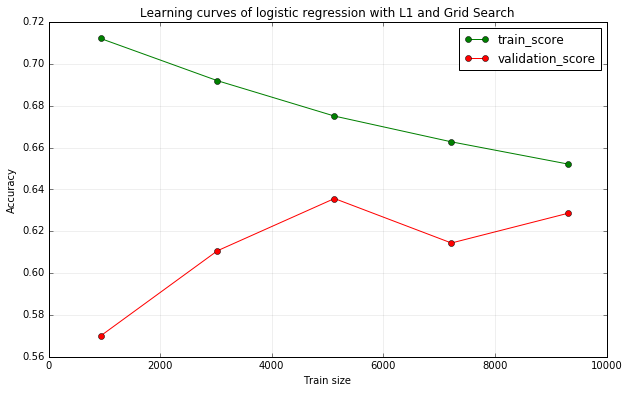

0.005


In [415]:
# Apply regularized logistic regression and Random Forest to dataset
LR_l1 = GridSearchCV(LogisticRegression(penalty='l1'), param_grid)

plot_learning_curves(LR_l1, X, Y, 'logistic regression with L1 and Grid Search')

print LR_l1_model.best_params_['C']

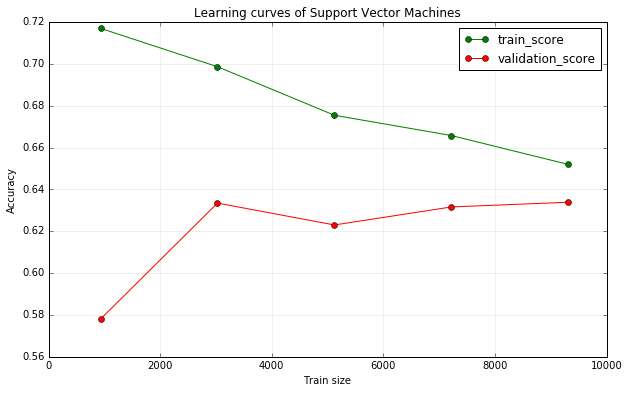

In [416]:
svc = GridSearchCV(LinearSVC(), param_grid={"C": [1, 0.1, 0.01, 0.001]})

plot_learning_curves(svc, X, Y, 'Support Vector Machines')

#SVC(kernel='rbf')

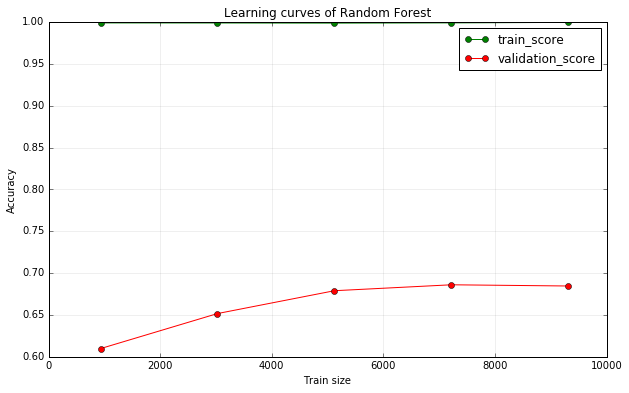

In [417]:
n_estimators = list(np.arange(10, 60, 20))
max_features = [None] 

hyperparameters = {
    'n_estimators': n_estimators, 
    'max_features': max_features
}

# Grid Search using cross-validation
RF = GridSearchCV(RandomForestClassifier(), param_grid=hyperparameters, cv=5, n_jobs=1)

plot_learning_curves(RF, X, Y, 'Random Forest')

# 5. Model building and validation

In [418]:
# build model and predict on test set
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=2)

LR_l1_model = LR_l1.fit(X_train, Y_train)

pred_Y = LR_l1_model.predict(X_val)

target_names = ['negative', 'positive']
print 'AUC = ', roc_auc_score(Y_val, pred_Y)
print(confusion_matrix(list(Y_val), list(pred_Y), labels=[0, 1]))
print(classification_report(Y_val, pred_Y, target_names=target_names))

AUC =  0.613610159485
[[1255  169]
 [ 694  367]]
             precision    recall  f1-score   support

   negative       0.64      0.88      0.74      1424
   positive       0.68      0.35      0.46      1061

avg / total       0.66      0.65      0.62      2485



# 6. Model predict and output

In [419]:
test_pred_Y = LR_l2_model.predict(X_test)

import csv
with open('kidsvideo_predicted.csv', 'w') as file:
    csv_writer = csv.writer(file)
    csv_writer.writerow(['id', 'pred'])
    for i, predict in enumerate(test_pred_Y):
        csv_writer.writerow([i+1, int(predict)])

ValueError: X has 330 features per sample; expecting 331